In [91]:
!pip install tqdm
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install autograd
!pip install pandas

38980.09s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


38985.81s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


38991.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


38996.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


39002.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


39008.05s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [92]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Utility function
def summarize_array(arr):
    return {
        "mean": np.mean(arr),
        "std": np.std(arr),
        "min": np.min(arr),
        "25%": np.percentile(arr, 25),
        "50% (median)": np.median(arr),
        "75%": np.percentile(arr, 75),
        "max": np.max(arr)
    }

n_features = 112
n_samples = 8124

In [93]:
# Load the data
X = np.zeros((n_samples, n_features))
y = np.zeros(n_samples, dtype=np.int64)
with open('mushrooms.txt', 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        y[i] = int(line[0])
        features = line[2:].split()
        features = [int(feature.split(':')[0]) for feature in features]
        features = [feature - 1 for feature in features]     # Features are 1-indexed in the dataset 
        X[i, features] = 1

y = y - 1       # Changing labels from 1 and 2 to 0 and 1

In [94]:
np.bincount(y)

array([3916, 4208])

/Users/matthieuneau/.pyenv/versions/3.12.8/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/matthieuneau/.pyenv/versions/3.12.8/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


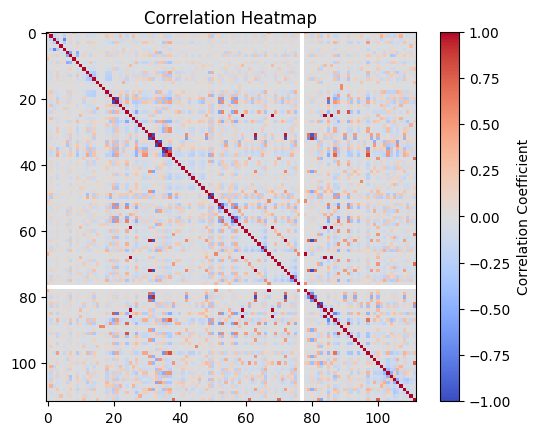

In [95]:
correlation_matrix =np.corrcoef(X.T)
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Heatmap')
plt.show()

0.023007450962255982


Text(0.5, 1.0, 'marginal absolute correlation with target')

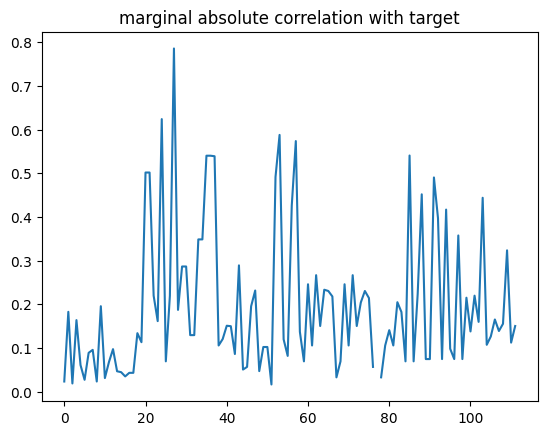

In [96]:
marginal_correlations = [np.abs(np.corrcoef(X[:,i], y)[0,1]) for i in range(n_features)]
print(marginal_correlations[0])

plt.plot(range(n_features), marginal_correlations)
plt.title('marginal absolute correlation with target')

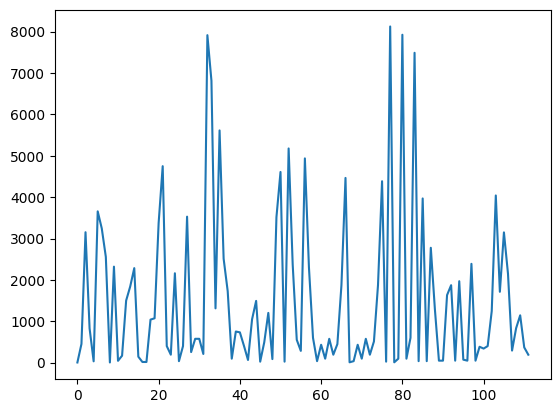

In [97]:
features_presence = [np.count_nonzero(X[:,i]) for i in range(n_features)]
plt.plot(range(n_features), features_presence)

### Number of features per entry
This shows that each row has exactly 21 features


In [98]:
features_per_row = X.sum(axis=1, dtype=np.int64)
print(np.bincount(features_per_row))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 8124]


### Row correlation

The rows are somewhat correlated, forming 5 or 6 distinct groups

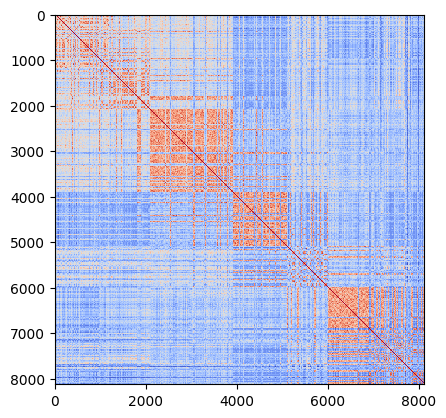

In [99]:
plt.imshow(np.corrcoef(X), cmap='coolwarm', interpolation='nearest')

### Q2

In [100]:
from autograd import grad
def loss(x: np.ndarray): 
    """x are the parameters. Confusing but consistent with the notations in the problem"""
    z = 1 + np.exp(-X @ x)
    z = 1/z
    return (1/n_samples) * np.sum((y - z)**2)

def manual_grad(x: np.ndarray):
    return (X.T @ ((-2 * np.exp(X@x)) * (1/(1+ np.exp(X@x))**3) * (np.exp(X@x)*(y - 1) + y)))/n_samples

grad_loss = grad(loss)

# Checking that our implementation of the gradient is correct
test_x = np.random.rand(n_features)
assert np.allclose(grad_loss(test_x), manual_grad(test_x))

### Q3

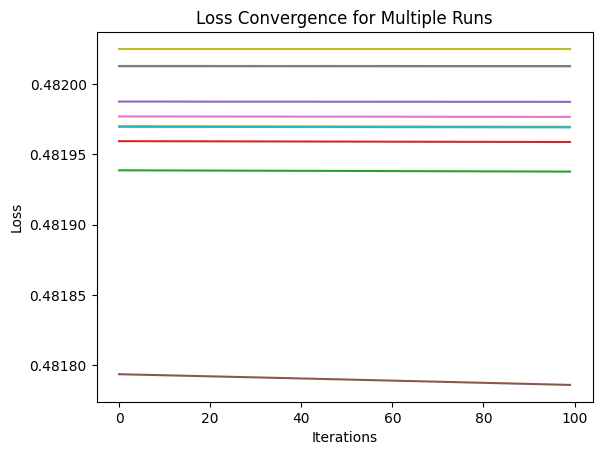

In [102]:
def grad_desc(x0: np.ndarray, alpha: float, n_iter: int):
    x = x0
    loss_history = []
    for i in range(n_iter):
        x = x - alpha * grad_loss(x)
        loss_history.append(loss(x))
    return x, loss_history

for _ in range(10):
    x0 = np.random.rand(n_features)
    alpha = 0.1
    n_iter = 100
    _, loss_history = grad_desc(x0, alpha, n_iter)  
    plt.plot(range(n_iter), loss_history)  

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Convergence for Multiple Runs")
plt.show()

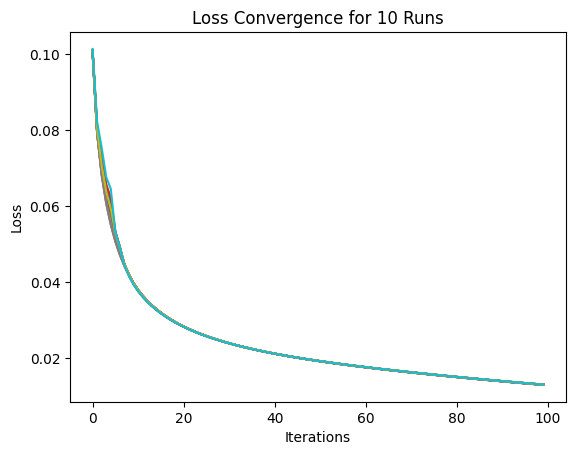

In [103]:
for _ in range(20):
    x0 = np.random.rand(n_features)/n_features
    alpha = 3  
    n_iter = 100  
    loss_history = grad_desc(x0, alpha, n_iter)[1]  # Run gradient descent and get loss history
    plt.plot(range(n_iter), loss_history)  # Plot the loss curve for this run

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Convergence for 10 Runs")
plt.show()


### Q4

In [124]:
def stochastic_grad(x: np.ndarray, batch_size: int = 1):
    indices = np.random.choice(n_samples, batch_size, replace=False)
    grad = np.zeros(n_features)
    for index in indices:
        grad += -2 * np.exp(np.dot(X[index], x)) * (np.exp(np.dot(X[index], x)) * (y[index] - 1) + y[index]) * X[index] / (1 + np.exp(np.dot(X[index], x)))**3
    return grad / batch_size

def stochastic_grad_desc(x0: np.ndarray, alpha: float, n_iter: int, batch_size: int = 1):
    x = x0
    loss_history = []
    for i in range(n_iter):
        x = x - alpha * stochastic_grad(x)
        loss_history.append(loss(x))
    return x, loss_history

# Check that it is equivalent to grad desc when batch size is equal to the number of samples
assert np.allclose(stochastic_grad(test_x, batch_size=n_samples), manual_grad(test_x))

In [ ]:
for _ in range(20):
    x0 = np.random.rand(n_features)/n_features
    alpha = 1
    n_iter = 100  
    loss_history = stochastic_grad_desc (x0, alpha, n_iter, 10)[1]  
    plt.plot(range(n_iter), loss_history) 

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Convergence for 10 Runs")
plt.show()

### Q5

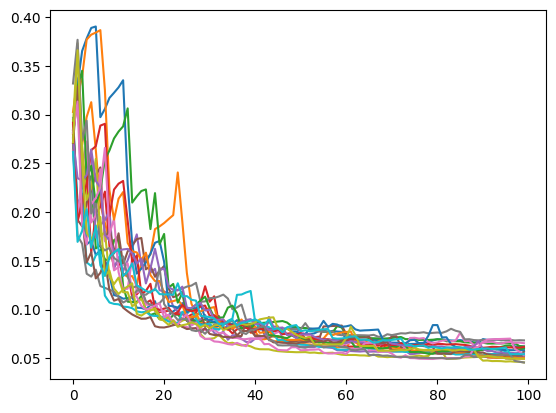

In [105]:
def adagrad(x0: np.ndarray, eta: float, n_iter: int, epsilon: float = 1e-8):
    x = x0
    G = np.zeros(n_features)
    loss_history = []
    for i in range(n_iter):
        g = stochastic_grad(x)
        G += g**2
        x = x - (eta/np.sqrt(G + epsilon)) * g
        loss_history.append(loss(x))
    return x, loss_history

for _ in range(20):
    x0 = np.random.rand(n_features)/n_features
    eta = 0.1
    n_iter = 100
    loss_history = adagrad(x0, eta, n_iter)[1]
    plt.plot(range(n_iter), loss_history)

### Q6

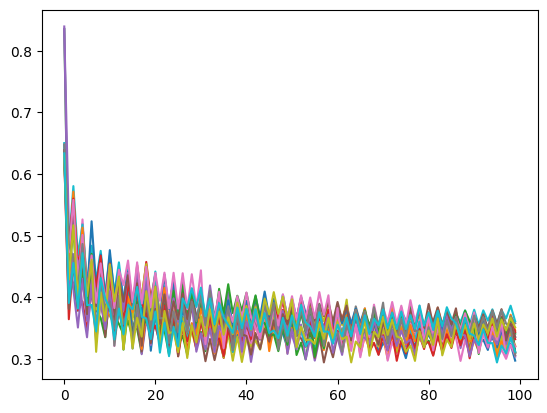

In [150]:
def regularized_loss(x: np.ndarray, lambda_: float):
    return loss(x) + np.linalg.norm(x, ord=1) * lambda_

def regularized_grad(x: np.ndarray, lambda_: float):
    return grad_loss(x) + lambda_ * np.sign(x)

def regularized_stochastic_grad(x: np.ndarray, lambda_: float, batch_size: int = 1):
    indices = np.random.choice(n_features, batch_size, replace=False)
    grad = np.zeros(n_features)
    for index in indices:
        grad += -2 * np.exp(np.dot(X[index], x)) * (np.exp(np.dot(X[index], x)) * (y[index] - 1) + y[index]) * X[index] / (1 + np.exp(np.dot(X[index], x)))**3
    grad/=batch_size
    grad += lambda_ * np.sign(x)
    return grad

def regularized_adagrad(x0: np.ndarray, eta: float, n_iter:int, lambda_: float, epsilon: float = 1e-8, batch_size: int = 1):
    x = x0
    G = np.zeros(n_features)
    loss_history = []
    for i in range(n_iter):
        g = regularized_stochastic_grad(x, lambda_, batch_size=1)
        G += g**2
        x = x - (eta/np.sqrt(G + epsilon)) * g
        loss_history.append(regularized_loss(x, lambda_))
    return x, loss_history

for _ in range(20):
    x0 = np.random.rand(n_features)/n_features
    eta = 0.1
    n_iter = 100
    lambda_ = 0.04
    loss_history = regularized_adagrad(x0, eta, n_iter, lambda_)[1]
    plt.plot(range(n_iter), loss_history)

### Q7

In [183]:
def bfgs(x0: np.ndarray, H0: np.ndarray, t0: float, c_armijo: float, c_curvature: float, n_iter: int):
    x = x0
    H = H0
    g = grad_loss(x)
    loss_history = []

    for _ in tqdm(range(n_iter)):
        p = - H @ g
        t = t0
        x_new = x + t * p
        g_new = grad_loss(x_new)
        count = 0

        while (loss(x + t*p) > loss(x) + c_armijo * t * np.dot(g, p)):
            t *= 0.5
            x_new = x + t * p
            g_new = grad_loss(x_new)
        while (- np.dot(p, g_new)) < (- c_curvature * np.dot(p, g)):
            t *= 0.5
            x_new = x + t * p
            g_new = grad_loss(x_new)

        s = x_new - x
        y = g_new - g
        if np.dot(s, y) > 0:
            H = (np.eye(n_features) - np.outer(s, y)/np.dot(s,y)).T @ H @ (np.eye(n_features) - np.outer(s, y)/np.dot(s,y)) + np.outer(s, s)/np.dot(s, y)
        # H = H + np.outer(s, s)/np.dot(s, y) - (H @ (np.outer(y, y)) @ H)/np.dot(y, H @ y)
        x, g = x_new, g_new
        loss_history.append(loss(x))

    return x, loss_history

100%|██████████| 100/100 [00:00<00:00, 122.45it/s]


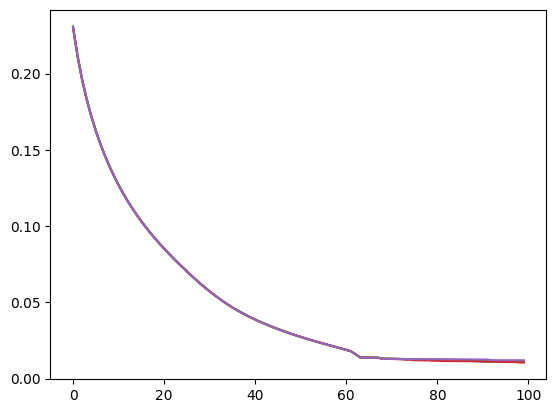

In [184]:
for _ in range(5):
    x0 = np.random.rand(n_features)/n_features
    H0 = np.eye(n_features)
    t0 = 1
    c_armijo = 0.01
    c_curvature = 0.9
    n_iter = 100
    loss_history = bfgs(x0, H0, t0, c_armijo, c_curvature, n_iter)[1]
    plt.plot(range(n_iter), loss_history)

### Q8

In [140]:
def stochastic_bfgs(x0: np.ndarray, H0: np.ndarray, t0: float, c_armijo: float, c_curvature: float, n_iter: int, batch_size=1):
    x = x0
    H = H0
    g = stochastic_grad(x, batch_size)
    loss_history = []

    for _ in tqdm(range(n_iter)):
        p = - H @ g
        t = t0
        x_new = x + t * p
        g_new = stochastic_grad(x_new, batch_size)
        count = 0

        while (loss(x + t*p) > loss(x) + c_armijo * t * np.dot(g, p)):
            t *= 0.5
            x_new = x + t * p
            g_new = stochastic_grad(x_new, batch_size)
        while (- np.dot(p, g_new)) < (- c_curvature * np.dot(p, g)):
            t *= 0.5
            x_new = x + t * p
            g_new = stochastic_grad(x_new, batch_size)

        s = x_new - x
        y = g_new - g
        H = H + np.outer(s, s)/np.dot(s, y) - (H @ (np.outer(y, y)) @ H)/np.dot(y, H @ y)
        x, g = x_new, g_new
        loss_history.append(loss(x))

    return x, loss_history

 80%|████████  | 80/100 [00:02<00:00, 36.09it/s]/var/folders/_y/2rw4wkns73v1mc9wlr3l0k_h0000gn/T/ipykernel_99917/3652537011.py:5: RuntimeWarning: overflow encountered in scalar power
  grad += -2 * np.exp(np.dot(X[index], x)) * (np.exp(np.dot(X[index], x)) * (y[index] - 1) + y[index]) * X[index] / (1 + np.exp(np.dot(X[index], x)))**3
 41%|████      | 41/100 [00:00<00:01, 49.77it/s]/var/folders/_y/2rw4wkns73v1mc9wlr3l0k_h0000gn/T/ipykernel_99917/2869227938.py:25: RuntimeWarning: invalid value encountered in divide
  H = H + np.outer(s, s)/np.dot(s, y) - (H @ (np.outer(y, y)) @ H)/np.dot(y, H @ y)
 68%|██████▊   | 68/100 [00:01<00:01, 23.13it/s]/Users/matthieuneau/.pyenv/versions/3.12.8/lib/python3.12/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/var/folders/_y/2rw4wkns73v1mc9wlr3l0k_h0000gn/T/ipykernel_99917/3652537011.py:5: RuntimeWarning: invalid value encountered in multiply
  grad += -2 * np.exp(np.dot(X[index], x))

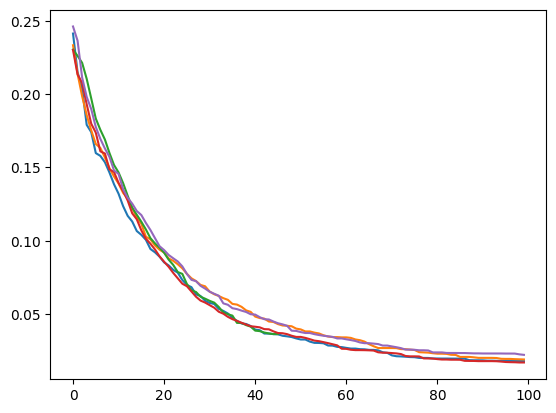

In [169]:
for _ in range(5):
    x0 = np.random.randn(n_features)/n_features
    H0 = np.eye(n_features)
    t0 = 1
    n_iter = 100
    batch_size = 500
    c_armijo = .01
    c_curvature = .9
    loss_history = stochastic_bfgs(x0, H0, t0, c_armijo, c_curvature, n_iter, batch_size)[1]
    plt.plot(range(n_iter), loss_history)

### Q9

### Adagrad
Adagrad only needs to access $B$ data points at each iteration as it calls $stochastic\_grad$ once per iteration and $n\_samples$ when computing the loss. This totals to $O(n\_samples + n\_iter \cdot B)$ data points accessed.

At each iteration, $x$ and $G$ are updated, amounting to a total of $O(n\_iter)$ updates of $d$-dimensional vectors.

### Stochastic BFGS
Let $k$ be an upper bound on the number of iterations in the while loop. Each iteration makes $O(k)$ calls to the $stochastic\_grad$ function, which itself accesses $B$ data points where $B$ is the batch size. At the end of each iteration, the loss is computed, which requires accessing all the data points, i.e., $n\_samples$. In total, Stochastic BFGS therefore accesses $O(B \cdot n\_iter \cdot k) + O(n\_samples)$ data points.

The update of $H$ at each iteration represents $d$ updates of $d$-dimensional vectors (since $H$ is of dimension $d \times d$), and the while loop makes $k$ updates. The other updates are $O(1)$. Overall, this amounts to $O(n\_iter \cdot d \cdot k)$.


### Q10

In [181]:
def regularized_bfgs(x0: np.ndarray, H0: np.ndarray, t0: float, c_armijo: float, c_curvature: float, lambda_:float, n_iter: int):
    x = x0
    H = H0
    g = regularized_grad(x, lambda_)
    regularized_loss_history = []

    for _ in tqdm(range(n_iter)):
        p = - H @ g
        t = t0
        x_new = x + t * p
        g_new = regularized_grad(x_new, lambda_)
        count = 0

        while (regularized_loss(x + t*p, lambda_) > regularized_loss(x, lambda_) + c_armijo * t * np.dot(g, p)):
            t *= 0.5
            x_new = x + t * p
            g_new = regularized_grad(x_new, lambda_)
        while (- np.dot(p, g_new)) < (- c_curvature * np.dot(p, g)):
            t *= 0.5
            x_new = x + t * p
            g_new = regularized_grad(x_new, lambda_)

        s = x_new - x
        y = g_new - g
        if np.dot(s, y) > 0:
            H = (np.eye(n_features) - np.outer(s, y)/np.dot(s,y)).T @ H @ (np.eye(n_features) - np.outer(s, y)/np.dot(s,y)) + np.outer(s, s)/np.dot(s, y)
        # H = H + np.outer(s, s)/np.dot(s, y) - (H @ (np.outer(y, y)) @ H)/np.dot(y, H @ y)
        x, g = x_new, g_new
        regularized_loss_history.append(regularized_loss(x, lambda_))

    return x, regularized_loss_history

  0%|          | 0/100 [00:00<?, ?it/s]/Users/matthieuneau/.pyenv/versions/3.12.8/lib/python3.12/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/matthieuneau/.pyenv/versions/3.12.8/lib/python3.12/site-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/Users/matthieuneau/.pyenv/versions/3.12.8/lib/python3.12/site-packages/autograd/numpy/numpy_vjps.py:74: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)
100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


0.045340246840322035


100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


0.043270919853561685


100%|██████████| 100/100 [00:20<00:00,  4.95it/s]

0.03849412286149496


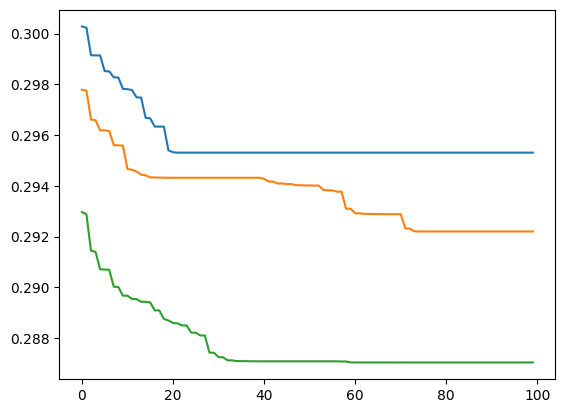

In [182]:
for _ in range(1):
    x0 = np.random.rand(n_features)/n_features
    H0 = np.eye(n_features)
    t0 = .1
    c_armijo = 0.001
    c_curvature = 0.9
    lambda_ = .1
    n_iter = 100
    x_res, loss_history = regularized_bfgs(x0, H0, t0, c_armijo, c_curvature, lambda_, n_iter)
    print(lambda_ * np.linalg.norm(x_res, ord=1))
    plt.plot(range(n_iter), loss_history) 

### Q11

In [ ]:
from collections import deque

def l_bfgs(x0: np.ndarray, H0: np.ndarray, t0: float, c_armijo: float, c_curvature: float, history_length: int, n_iter: int):
    x = x0
    H = H0
    s_history = np.zeros((history_length, n_features))
    g = grad_loss(x)
    loss_history = dequeue(maxlen=history_length)

    for i in tqdm(range(n_iter)):
        for l in range(len(queue)):
            if np.dot(s_history[-l], y_history[-l]) > 0:
                gamma = np.dot(s_history[-l], g) / np.dot(s_history[-l], y_history[-l])
                q -= gamma * y_history[-l] 

        for l in range(len(queue)):
            if np.dot(s_history[-l], y_history[-l]) > 0:
                delta = np.dot(s_history[-l], g) / np.dot(s_history[-l], y_history[-l])
                q += (gamma - delta) * y_history[-l]  ## Gamma_l ??? 
                
               
        p = - H @ g
        t = t0
        x_new = x + t * p
        g_new = grad_loss(x_new)
        count = 0

        while (loss(x + t*p) > loss(x) + c_armijo * t * np.dot(g, p)):
            t *= 0.5
            x_new = x + t * p
            g_new = grad_loss(x_new)
        while (- np.dot(p, g_new)) < (- c_curvature * np.dot(p, g)):
            t *= 0.5
            x_new = x + t * p
            g_new = grad_loss(x_new)

        s = x_new - x
        y = g_new - g
        if np.dot(s, y) > 0:
            H = (np.eye(n_features) - np.outer(s, y)/np.dot(s,y)).T @ H @ (np.eye(n_features) - np.outer(s, y)/np.dot(s,y)) + np.outer(s, s)/np.dot(s, y)
        # H = H + np.outer(s, s)/np.dot(s, y) - (H @ (np.outer(y, y)) @ H)/np.dot(y, H @ y)
        x, g = x_new, g_new
        loss_history.append(loss(x))

    return x, loss_history

In [205]:
q = deque(maxlen=3)
q.append(1)
q.append(2)
q.append(3)
q[-1]

3